In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Flatten, AveragePooling2D, UpSampling2D, Reshape, Dropout,Conv2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import cv2

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential


In [4]:
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Dense, Reshape, Input

In [5]:
dt = 0.02
dx = 0.1
dy = 0.1



def xx_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[0]], [[0]]],
            [[[1]], [[-2]], [[1]]],
            [[[0]], [[0]], [[0]]]
        ])
    return tf.constant(f,dtype='float32')

def yy_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[1]], [[0]]],
            [[[0]], [[-2]], [[0]]],
            [[[0]], [[1]], [[0]]]
        ])
    return tf.constant(f, dtype='float32')

def bulid_xx_derivate(dx):
    input_tensor = Input(shape=(600,180,1))

    x = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=xx_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    
  

    model = Model(inputs=input_tensor, outputs=dt*x/(dx**2))
    return model

def bulid_yy_derivate(dy):
    input_tensor = Input(shape=(600,180,1))

    y = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=yy_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    


    model = Model(inputs=input_tensor, outputs=dt* y/(dy**2))
    return model

def dynamical_model(diffusion):

    inputs1 = Input(shape=(600,180,1))

    inputs3 = Input(shape=(1))

    point_wise_model = Sequential()
    point_wise_model.add(Dense(16,input_shape=(1, )))
    point_wise_model.add(Dense(16,activation='relu'))
    point_wise_model.add(Dense(1))


    diffusion_model = Sequential()
    diffusion_model.add(Dense(16,input_shape=(1,),activation='relu'))
    diffusion_model.add(Dense(1,activation='sigmoid'))

    model_xx = bulid_xx_derivate(dx)
    model_yy = bulid_yy_derivate(dy)



    model_xx.layers[1].trainable = False
    model_yy.layers[1].trainable = False

    xx_derivate = model_xx(inputs1)
    yy_derivate = model_yy(inputs1)

    lap = xx_derivate+yy_derivate




    model = Sequential()

    R1 = layers.Lambda(lambda x: dt*x*(1-x))(inputs1)

    D3 = 0.0045*diffusion*lap
    flat_inputs = tf.reshape(inputs1, shape=(-1, 1))
    flat_outputs = point_wise_model(flat_inputs)
    R2 = tf.reshape(flat_outputs, shape=(-1,600,180,1))

    R3 = layers.Multiply()([R1, R2])


    outputs = layers.Add()([R3, D3, inputs1])
    model = Model(inputs=[inputs1, inputs3], outputs=[outputs])
    pp1 = keras.models.load_model("pointwise/p1")
    pw = pp1.get_weights()
    model.layers[2].set_weights(pw) 
    
    return model

In [6]:
def pde_pred(model,u):
    u1 = np.array(1).reshape((1,1))
    udt = model.predict([u,u1])
    return udt

def plot_images(*images):
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 4))
    for a, i in zip(ax, images):
        im = a.imshow(np.squeeze(i), vmin=0, vmax=1)
        fig.colorbar(im, ax=a)
        a.set_xlim([0, 180])
        a.set_ylim([600, 0])

In [7]:
def transform_1(img):
    temp = np.zeros((400,120))
    temp[:] =1
    temp[120:280,10:110] = img
    resize = cv2.resize(temp, (180,600), interpolation = cv2.INTER_AREA)
    return resize

def transform_2(img):
    resize = cv2.resize(img, (120,400), interpolation = cv2.INTER_AREA)
    img1 = resize[120:280,10:110]
    return img1

def get_toughness_img(ncut):
    cut = img_ts[ncut,:,:].reshape((1,600,180,1))
    plot_images1(transform_2(cut.reshape((600,180))),transform_2(pred(model,cut,20).reshape((600,180))),transform_2(pred(model,cut,40).reshape((600,180))),transform_2(pred(model,cut,60).reshape((600,180))),transform_2(pred(model,cut,80).reshape((600,180))),transform_2(pred(model,cut,100).reshape((600,180))))

    
    

In [8]:
imgs = np.load("Toughness_img.npy")                     # load initial cut images
img_col = np.load('toughness_collection_cut.npy')/255.0 # load cut image at the collection time point
CNN_model = keras.models.load_model("CNN_toughness")    # load CNN-Toughness model
model = dynamical_model(4.17)                           # load EFM model

In [9]:
def transform(img): 
    temp = np.zeros((400,120))
    temp[:] =1
    temp[120:280,10:110] = img
    resize = cv2.resize(temp, (180,600), interpolation = cv2.INTER_AREA)
    return resize


def transform_inverse(img):
    resize = cv2.resize(img, (100,400), interpolation = cv2.INTER_AREA)
    img1 = resize[120:280,:]
    return img1

In [10]:
def toughness_evolution(img,dyn_model,sta_model,times):
    img_ts = transform(img)
    img_pred = np.zeros((times,600,180,1))
    tgn_pred = np.zeros((times,1))
    tgn_pred[0:1] =  np.array(sta_model(img.reshape((1,160,100,1))))
    img_pred[0:1] = img_ts.reshape(1,600,180,1)
    for i in range(times-1):
        img_pred[i+1:i+2] = pde_pred(dyn_model,img_pred[i:i+1])
        temp_ts = transform_inverse(img_pred[i+1:i+2].reshape((600,180)))
        tgn_pred[i+1:i+2] =np.array(sta_model(temp_ts.reshape((1,160,100,1))))
    return img_pred,tgn_pred

In [11]:
# information = [y1,y2,xt,yt,h,T,index]
#[y1,y2] the range of toughness evolution 
#[xt,yt]: location of truth data
# h: toughness collection time point(hour)
# T: terminal time of the healing process
# index: index of the cut image


cut_information = [
    [60,200,45,96.84,15,140,23],
    [60,200,45,121.70,15,140,13],
    [60,200,120,118.09,40,140,28],
    [60,200,120,113.15,40,140,27],
    [60,90,24,89.05,8,140,26],
    [60,200,36,120.37,12,140,24],
    [60,200,24,86.35,8,140,36],
    [60,200,24,94.67,8,140,32]
    ]

In [12]:
def plot_images(*images):
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 4))
    for a, i in zip(ax, images):
        im = a.imshow(np.squeeze(i), vmin=0, vmax=1)
        a.axis('off')
        a.set_xlim([10, 170])
        a.set_ylim([500, 100])

In [13]:
def plt_evolution(ncuts):
    initial_step = 2
    time_step = 20
    
    img = img_col[ncuts]
    y1,y2,xt,yt,h,time ,index = cut_information[ncuts]
    xx,yy = toughness_evolution(img,model,CNN_model,time+1)
    np.save('toughness_evolution/'+str(ncuts)+'.npy',yy[5:])
    
    plt.figure(figsize=(8,6),dpi=80)
    plt.ylim([y1,y2])
    xgrid = np.linspace(0,time*time_step,time)
    plt.ylabel('Toughness Value',fontsize=20)
    plt.xlabel('Time /mins',fontsize=20)
    plt.yticks(np.arange(y1, y2+40, 30))
    plt.plot(xt*time_step-initial_step,CNN_model(imgs[index].reshape(1,160,100,1))*150+50,'gx',markersize=9,label = 'CNN(u_true)') 
    plt.plot(xt*time_step-initial_step,yt,'ro',markersize=7,label = 'Truth at '+str(h)+'h') 
    plt.plot(xt*time_step-initial_step,yy[h*3+initial_step]*150+50,'bo',markersize=7,label = 'CNN(u_pred)')
    plt.plot(xgrid[:-1],yy[2:]*150+50)
    plt.legend(loc=2, prop={'size': 15})
    plt.tick_params(axis='both', which='major', labelsize=20)

    


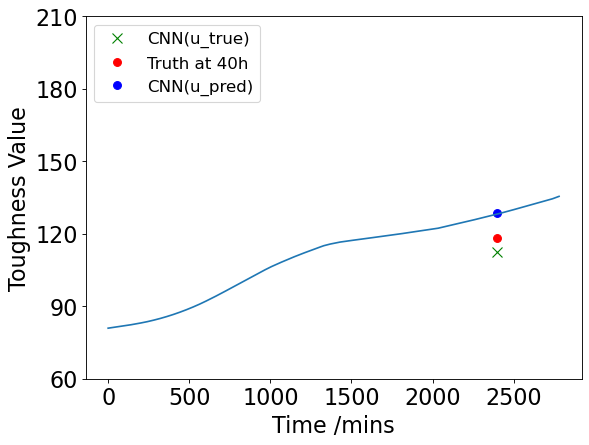

In [14]:
plt_evolution(2)

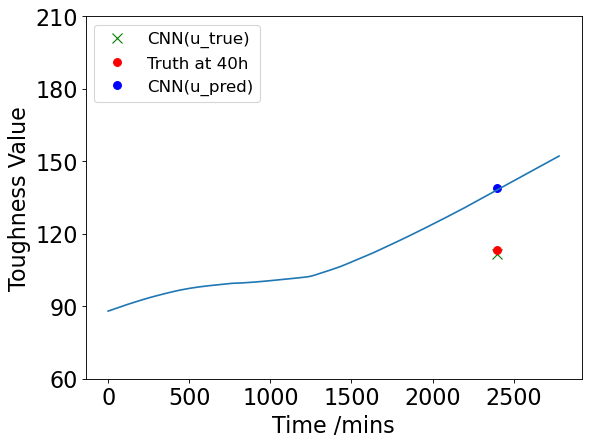

In [15]:
plt_evolution(3)

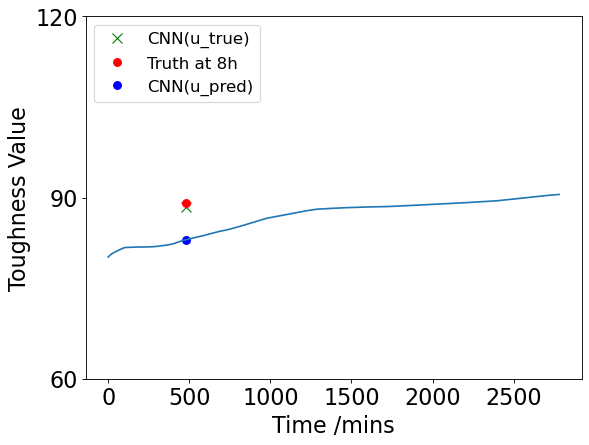

In [16]:
plt_evolution(4)

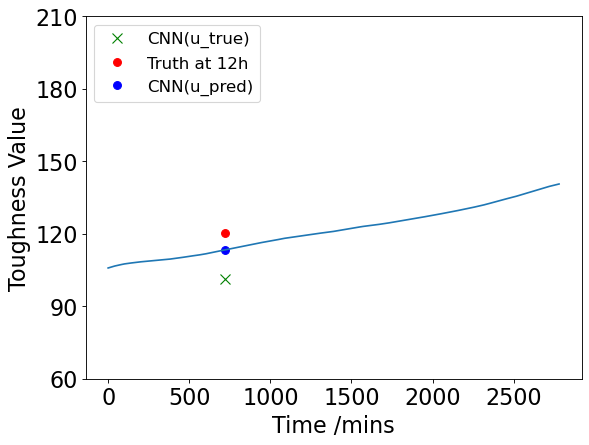

In [17]:
plt_evolution(5)

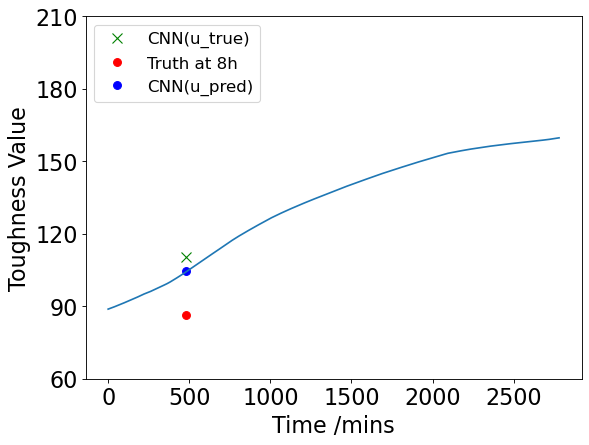

In [18]:
plt_evolution(6)

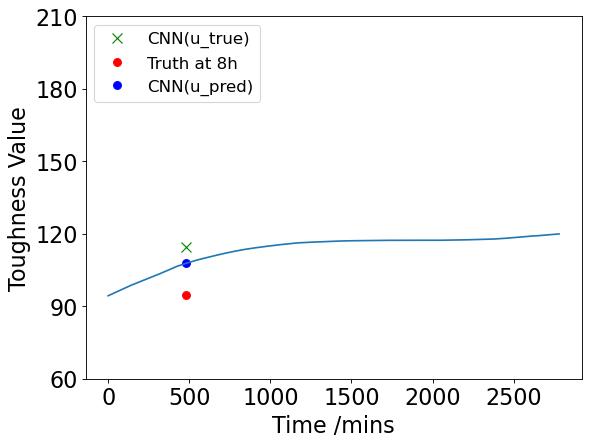

In [19]:
plt_evolution(7)